Bailey Griswold, bg1672  
Goal: identify the best performing covariance model (model that takes this period's features and this periods home value)

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as pl
import datetime
import pickle
import seaborn as sns

from fancyimpute import KNN
from scipy import stats

import statsmodels.formula.api as smf  

from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import RandomizedLasso
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import ElasticNet
import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
def drop_columns(df,phrase,dropped_cols=False):
    '''Drop all columns in dataframe df that contain substring phrase'''
    start_len = len(df.columns)
    drop_cols = []
    for i in df.columns:
        if phrase in i:
            drop_cols.append(i)
            df.drop([i], axis=1, inplace=True)
    #print ('Total Columns Dropped: {}'.format(len(drop_cols)))
    if dropped_cols == True:
        print ('Dropped Columns: {}'.format(drop_cols))

In [3]:
def column_filter(df,phrase):
    '''produces a list of columns that contain the phrase'''
    start_len = len(df.columns)
    keep_cols = []
    for i in df.columns:
        if phrase in i:
            keep_cols.append(i)
    #print ('Columns matching filter: {}'.format(len(keep_cols)))
    return (keep_cols)

In [4]:
def mdl_eval(mdl, output, regressors, test, train, color, show=True):
    ''' For a specific model, produce the in sample R square value, the out of sample r sqaure, 
        and the median absolute error. Returns the Radj and Median Absolute Error '''
    
    Rout = r2_score(test[output], mdl.predict(test[regressors]))
    R = Rout
    p = len(regressors)
    n = len(test)
    Radj = R - ((1 - R)*((p)/(n-p-1)))
    model_score = median_absolute_error(test[output], mdl.predict(test[regressors]))
    

    
    if show == True:
        
        print ('In Sample RSquared: ', mdl.score(train[regressors], train[output]))
        print ('Out of sample R-Squared: ', Rout)
        print ('Out of sample Adjusted R-Squared: ', Radj)
        print ('Model Eval (Median Absolute Error): ', model_score)
        
        pl.figure(figsize=(8,6))
        pl.title("Radj = {}, p = {}".format(Radj, p), fontsize=16)
        pl.plot(test[output], mdl.predict(test[regressors]), 'o', alpha=.5, c=color)
        pl.plot(test[output], test[output])
        pl.xlabel('Observed Values', fontsize=14)
        pl.ylabel('Predicted Values', fontsize=14)
    
    return (Radj, model_score)

In [5]:
def feat_sel(df, output, model='rf', alpha=100, feat_num=20):
    '''
    performs random forest or lasso fit on specified dataframe and produces a list of 
    the top specified number of features and returns a sorted list of the features and their scores.
    '''
    #regressors = features
    regressors = list(set(df.columns) - set([output]))

    y = df[output]
    X = df[regressors] #select all the columns after id and geography -- the regressors
    names = X.columns

    rlasso = RandomizedLasso(alpha=alpha,random_state=0, normalize=True, fit_intercept=True)
    rlasso.fit(X, y)

    rf = RandomForestRegressor(random_state=0,n_estimators=100)
    rf.fit(X, y)

    if model == 'lasso':
        feat_sort = (sorted(zip(map(lambda x: round(x, 10), rlasso.scores_), names), reverse=True))
    else: 
        feat_sort = (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))
        print ('R-Score', rf.score(X, y))

    pl.figure(figsize=(8,6))
    pl.title("{} Feature importance".format(model))
    pl.bar(np.arange(feat_num), pd.DataFrame(feat_sort)[0][:feat_num], align='center')
    #pl.xticks(np.arange(feat_num), fontsize=8)
    pl.ylabel('Importance Score')

    print("{} Feature ranking:".format(model), pd.DataFrame(feat_sort)[:5])
    return feat_sort

## 1. Load dataset - Covariance 10

In [79]:
#set output variable
output = 'ZHVI_AllHomes_current'

In [80]:
path = './data/dataframes/covar10.csv'
data = pd.read_csv(path)
data['FIPS'] = data.FIPS.apply(str)
data['FIPS'] = data.FIPS.str.zfill(5)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
print('Cols: ', len(data.columns), 'Rows: ', len(data))
drop_columns(data, '_y')
print('Cols, after dropping doubles: ', len(data.columns), 'Rows: ', len(data))
data.head()

Cols:  29 Rows:  3330
Cols, after dropping doubles:  29 Rows:  3330


,Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__Median_dollars,Percent__GROSS_RENT__1500_or_more,Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__2000_or_more,County_PriceToRentRatio_AllHomes_current,Estimate__GROSS_RENT__Median_dollars,Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__700_to_999_log,rent_price_persqft_Sfr_current,Percent__HOUSE_HEATING_FUEL__Occupied_housing_units__No_fuel_used,rent_price_persqft_Mfr5Plus_current,Estimate__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__Mean_household_income_dollars,...,00900_log,Percent__SELECTED_MONTHLY_OWNER_COSTS_AS_A_PERCENTAGE_OF_HOUSEHOLD_INCOME_SMOCAPI__Housing_unit_without_a_mortgage_excluding_units_where_SMOCAPI_cannot_be_computed__Less_than_100_percent_log,rent_price_persqft_CondoCoop_current,Percent__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__Families__200000_or_more_log,"Cumulative Estimates of the Components of Population Change - April 1, to July 1, - Net Migration - Totalpercent",Percent__SELECTED_MONTHLY_OWNER_COSTS_AS_A_PERCENTAGE_OF_HOUSEHOLD_INCOME_SMOCAPI__Housing_units_with_a_mortgage_excluding_units_where_SMOCAPI_cannot_be_computed__Less_than_200_percent,ZHVI_AllHomes_current,FIPS,STATE,YEAR
0,1509.0,8.0,21.2,10.817500,937.0,2.341806,0.762661,0.469425,0.798930,60147.0,...,2.227087,3.879501,0.622900,1.019390,0.936700,43.724396,162683.333333,10001,0,2011.0
1,1622.0,12.9,27.4,12.110833,968.0,2.240710,0.827405,0.317977,0.986705,83602.0,...,2.474629,3.487363,1.166828,1.984099,0.045943,37.112456,201633.333333,10003,0,2011.0
2,1436.0,16.2,22.5,13.653265,943.0,2.631889,0.781084,0.474703,0.755486,69217.0,...,2.453768,3.601050,0.939207,0.809759,1.502022,33.915347,285214.416667,10005,0,2011.0
3,2224.0,33.6,57.3,12.933333,1216.0,1.609438,0.955482,0.560425,2.683124,98177.0,...,2.940992,3.817600,2.913755,2.425417,1.746613,44.195587,358558.333333,11001,1,2011.0
4,1458.0,8.8,24.0,10.775833,827.0,2.890372,0.748822,0.627353,0.743345,58428.0,...,2.281225,3.896214,0.780640,1.703114,0.251840,45.433816,136316.666667,12001,2,2011.0


## 3. Create Training, Validation, and Test Datasets

In [81]:
df = data

### b. Training, Validation, Test data

In [82]:
features = list(set(df.columns) - set([output, 'FIPS', 'YEAR'] ))

In [83]:
train = df[df.YEAR <= 2014]
test1 = df[df.YEAR == 2015]

Create a subsample of 20% of data to train covariance model. Use model to predict for the rest of the 80% of data and the next year's data.

In [84]:
x_train, x_test, y_train, y_test = train_test_split(df[features],df[output], train_size=.2, random_state=0, stratify=df.STATE)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [85]:
train = pd.concat([x_train, y_train], axis=1)

In [86]:
val = pd.concat([x_test, y_test], axis=1)

## 6. Modeling

### ** * a. OLS * **

In [87]:
mdl_res = [(0, 0)]
res_labels = ['Model', 'N_Features', 'Out_of_sample_data', 'R_Adj', 'MAE']

In Sample RSquared:  0.895848651044
Out of sample R-Squared:  0.829058558735
Out of sample Adjusted R-Squared:  0.82737312928
Model Eval (Median Absolute Error):  12361.1155595


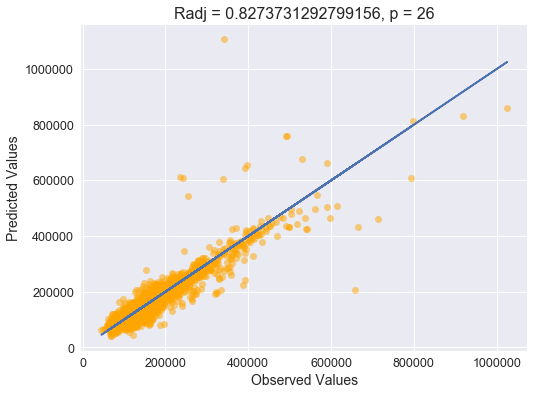

In [88]:
lm = LinearRegression()
lm.fit(train[features], train[output])
radj, mae = mdl_eval(lm, output, features, val, train, 'orange')
mdl_res.append(('OLS', len(features), 'val', radj, mae))

Radj, mae = mdl_eval(lm, output, features, test1, train, 'orange', show=False)
mdl_res.append(('OLS', len(features), 'test', Radj, mae))

A baseline OLS Model of all the features in the dataset predicting the Zillow Home Values. 205 of the data was used to train the model, and it was validated against the other 80%. The graph shows the performance of the model in predicting the home values for the 80% of the data not included in the training set. The values for each features are from the same year as the output home values.

### ** * b. Random Forest * **

Determine correct parameters to use.

Optial Paramter Output:  
n_estimators           100.000000  
min_samples_leaf         1.000000  
min_samples_split        2.000000  
max_depth                     NaN  
max_leaf_nodes                NaN  
outRadj                  0.877777  
MAE                  11052.268542  

Random Forest Model 

In Sample RSquared:  0.976316142429
Out of sample R-Squared:  0.874845549254
Out of sample Adjusted R-Squared:  0.873611565288
Model Eval (Median Absolute Error):  11213.3901515


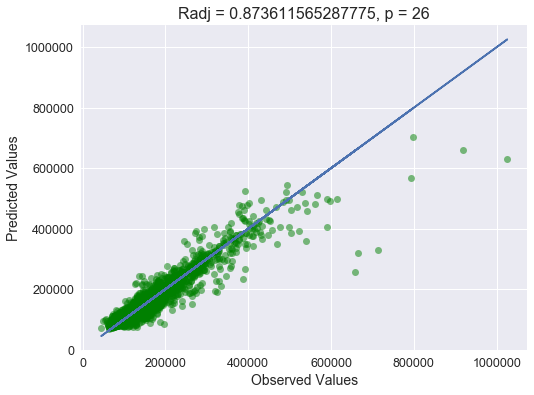

In [89]:
rf = RandomForestRegressor(random_state =42,
                                                n_estimators = 100,
                                                min_samples_leaf = 1,
                                                min_samples_split = 2,
                                                max_depth = None,
                                                max_leaf_nodes = None)
rf.fit(train[features], train[output])
print ('Random Forest Model', '\n')
Radj, mae = mdl_eval(rf, output, features, val, train, 'green')
mdl_res.append(('RF Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(rf, output, features, test1, train, 'green', show=False)
mdl_res.append(('RF Regr',len(features), 'test', Radj, mae))

### ** * c. Gradient Boosted Regressor * **

Optimal Paramter Output:  
n_estimators          100.000000  
min_samples_leaf       10.000000  
min_samples_split       2.000000  
max_depth                    NaN  
max_leaf_nodes               NaN  
outRadj                 0.854718  
MAE                  9637.709255  

Gradient Boosting 

In Sample RSquared:  0.888913308343
Out of sample R-Squared:  0.837355602405
Out of sample Adjusted R-Squared:  0.83575197922
Model Eval (Median Absolute Error):  10052.6563387


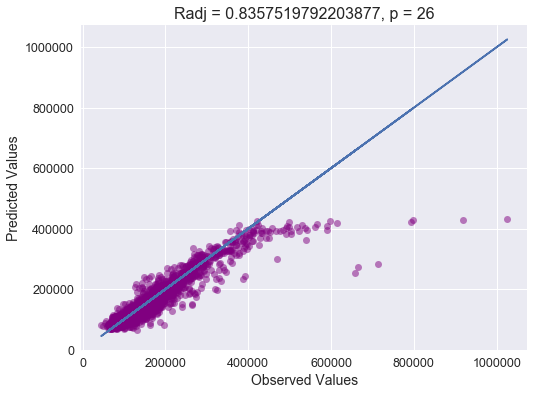

In [90]:
gb = GradientBoostingRegressor(random_state=42,loss = 'lad', n_estimators = 100,
                               min_samples_leaf =10, max_depth = None,
                               min_samples_split = 2, max_leaf_nodes = None)
gb.fit(train[features],train[output])
print ('Gradient Boosting', '\n')
Radj, mae = mdl_eval(gb, output, features, val, train, 'purple')
mdl_res.append(('GB Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(gb, output, features, test1, train, 'green', show=False)
mdl_res.append(('GB Regr',  len(features), 'test', Radj, mae))

### ** * d. elastic net * **

Parameter Output:  
alphas         100.000000  
l1_ratios        1.000000  
OutRAdj          0.842929  
MAE          11908.340625  

Elastic net Model 

In Sample RSquared:  0.895848456408
Out of sample R-Squared:  0.829122277228
Out of sample Adjusted R-Squared:  0.827437476017
Model Eval (Median Absolute Error):  12341.8182737


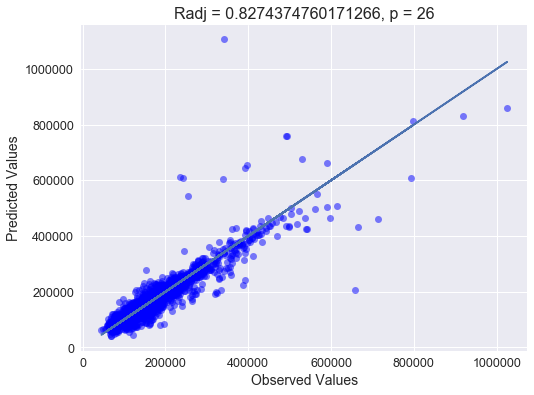

In [91]:
en = ElasticNet(random_state=0,normalize=True,alpha=0.100,l1_ratio=1,max_iter=10000)
en.fit(train[features], train[output])
print ('Elastic net Model', '\n')
Radj, mae = mdl_eval(en, output, features, val, train, 'blue')
mdl_res.append(('EN', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(en, output, features, test1, train, 'green', show=False)
mdl_res.append(('EN', len(features), 'test', Radj, mae))

In [92]:
res_c10 = pd.DataFrame.from_records(mdl_res, columns=res_labels)
res_c10.drop(0, inplace=True)

## 1. Load dataset - Covariance 85

In [93]:
#set output variable
output = 'ZHVI_AllHomes_current'

In [94]:
path = './data/dataframes/covar85.csv'
data = pd.read_csv(path)
data['FIPS'] = data.FIPS.apply(str)
data['FIPS'] = data.FIPS.str.zfill(5)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
print('Cols: ', len(data.columns), 'Rows: ', len(data))
drop_columns(data, '_y')
print('Cols, after dropping doubles: ', len(data.columns), 'Rows: ', len(data))
data.head()

Cols:  45 Rows:  10601
Cols, after dropping doubles:  45 Rows:  10601


,Adjusted_gross_income_per_return,19300,County_PriceToRentRatio_AllHomes_current,Dividends_before_exclusion_per_return,04800,04470,07100,18300,10300,02500,...,18425,Dpct,N59660_log,00300,Property_crimepercent,TotalVotes_log,ZHVI_AllHomes_current,FIPS,STATE,YEAR
0,41.148529,7.574493,10.108351,0.549261,47.703963,22.411182,1.219085,7.707586,9.020281,12.002002,...,6.370466,47.2,9.15836,1.79015,3.290519,10.784234,100716.666667,10001,0,2000
1,60.782989,7.574493,10.108351,2.170544,47.703963,22.411182,1.219085,7.707586,9.020281,12.002002,...,6.370466,59.9,9.15836,1.79015,1.099982,12.269329,131600.000000,10003,0,2000
2,43.315463,7.574493,10.108351,1.032915,47.703963,22.411182,1.219085,7.707586,9.020281,12.002002,...,6.370466,55.2,9.15836,1.79015,2.450171,11.347378,94150.000000,12001,1,2000
3,39.546069,7.574493,10.108351,0.652550,47.703963,22.411182,1.219085,7.707586,9.020281,12.002002,...,6.370466,32.1,9.15836,1.79015,4.119760,10.974814,107866.666667,12005,1,2000
4,45.895386,7.574493,10.108351,1.153127,47.703963,22.411182,1.219085,7.707586,9.020281,12.002002,...,6.370466,44.6,9.15836,1.79015,0.829787,12.287952,88750.000000,12009,1,2000


## 3. Create Training, Validation, and Test Datasets

In [95]:
df = data

### b. Training, Validation, Test data

In [96]:
df.drop(column_filter(df, '_next'), axis=1, inplace=True)
#Check row and column length
print ('cols: ', len(df.columns), 'rows: ', len(df))

cols:  45 rows:  10601


In [97]:
features = list(set(df.columns) - set([output, 'FIPS', 'YEAR'] ))

In [98]:
train = df[df.YEAR <= 2013]
test1 = df[df.YEAR == 2014]

Create a subsample of 20% of data to train covariance model. Use model to predict for the rest of the 80% of data and the next year's data.

In [99]:
x_train, x_test, y_train, y_test = train_test_split(df[features],df[output], train_size=.2, random_state=0, stratify=df.STATE)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [100]:
train = pd.concat([x_train, y_train], axis=1)

In [101]:
val = pd.concat([x_test, y_test], axis=1)

## 6. Modeling

In [102]:
mdl_res = [(0, 0)]
res_labels = ['Model', 'N_Features', 'Out_of_sample_data', 'R_Adj', 'MAE']

### ** * a. OLS * **

In Sample RSquared:  0.674351374788
Out of sample R-Squared:  0.577869898648
Out of sample Adjusted R-Squared:  0.575768753322
Model Eval (Median Absolute Error):  19651.8978497


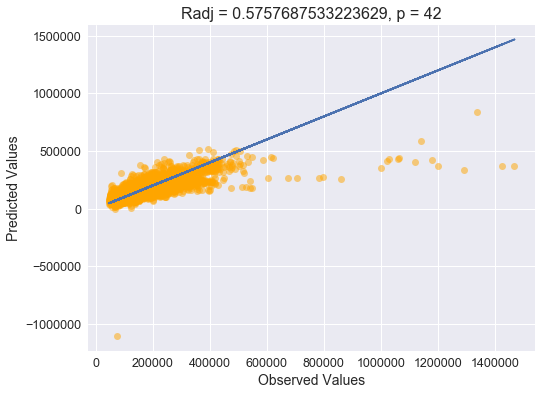

In [103]:
lm = LinearRegression()
lm.fit(train[features], train[output])
radj, mae = mdl_eval(lm, output, features, val, train, 'orange')
mdl_res.append(('OLS', len(features), 'val', radj, mae))

Radj, mae = mdl_eval(lm, output, features, test1, train, 'orange', show=False)
mdl_res.append(('OLS', len(features), 'test', Radj, mae))


A baseline OLS Model of all the features in the dataset predicting the Zillow Home Values. 205 of the data was used to train the model, and it was validated against the other 80%. The graph shows the performance of the model in predicting the home values for the 80% of the data not included in the training set. The values for each features are from the same year as the output home values.

### ** * b. Random Forest * **

Determine correct parameters to use.

Optimal Paramter Output:  
n_estimators           100.000000  
min_samples_leaf         1.000000  
min_samples_split        2.000000  
max_depth                     NaN  
max_leaf_nodes                NaN  
outRadj                  0.752132  
MAE                  13921.500000  

Random Forest Model 

In Sample RSquared:  0.964124135469
Out of sample R-Squared:  0.760984771751
Out of sample Adjusted R-Squared:  0.759795077559
Model Eval (Median Absolute Error):  13777.8333333


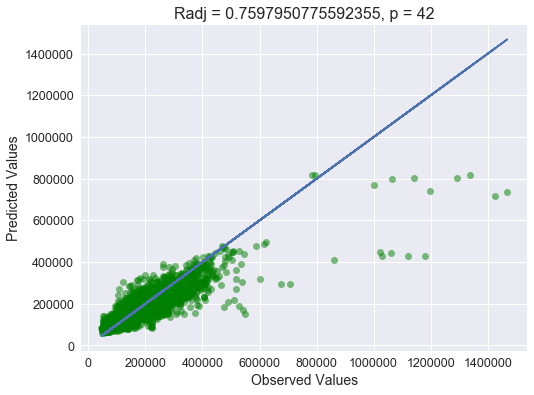

In [104]:
rf = RandomForestRegressor(random_state =42,
                                                n_estimators = 100,
                                                min_samples_leaf = 1,
                                                min_samples_split = 2,
                                                max_depth = None,
                                                max_leaf_nodes = None)
rf.fit(train[features], train[output])
print ('Random Forest Model', '\n')
Radj, mae = mdl_eval(rf, output, features, val, train, 'green')
mdl_res.append(('RF Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(rf, output, features, test1, train, 'green', show=False)
mdl_res.append(('RF Regr',len(features), 'test', Radj, mae))

### ** * c. Gradient Boosted Regressor * **

n_estimators           100.000000  
min_samples_leaf         1.000000  
min_samples_split       20.000000  
max_depth                     NaN  
max_leaf_nodes                NaN  
outRadj                  0.674293  
MAE                  12215.235104  

Gradient Boosting 

In Sample RSquared:  0.890618847748
Out of sample R-Squared:  0.700260488315
Out of sample Adjusted R-Squared:  0.698768540046
Model Eval (Median Absolute Error):  12410.7755765


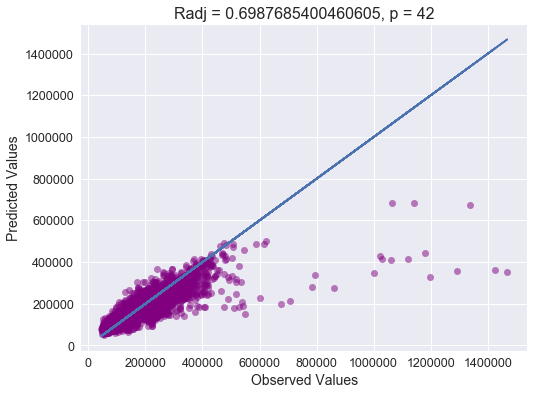

In [105]:
gb = GradientBoostingRegressor(random_state=42,loss='lad', n_estimators=100,
                               min_samples_leaf=1, max_depth=None,
                               min_samples_split=20, max_leaf_nodes=None)
gb.fit(train[features],train[output])
print ('Gradient Boosting', '\n')
Radj, mae = mdl_eval(gb, output, features, val, train, 'purple')
mdl_res.append(('GB Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(gb, output, features, test1, train, 'green', show=False)
mdl_res.append(('GB Regr',  len(features), 'test', Radj, mae))

### ** * d. elastic net * **

alphas           0.100000  
l1_ratios        1.000000  
OutRAdj          0.588327  
MAE          19071.555241  

Elastic net Model 

In Sample RSquared:  0.674344357784
Out of sample R-Squared:  0.580842523643
Out of sample Adjusted R-Squared:  0.578756174508
Model Eval (Median Absolute Error):  19619.8532484


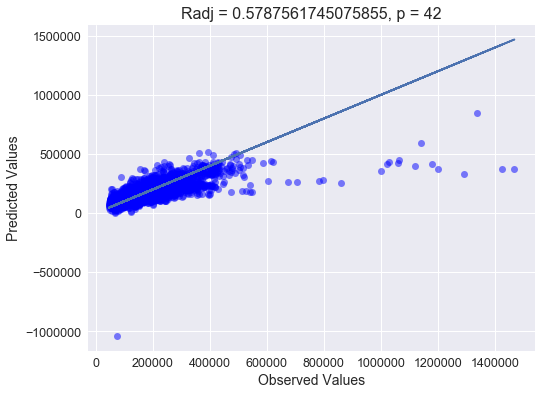

In [106]:
en = ElasticNet(random_state=0,normalize=True,alpha=0.1,l1_ratio=1,max_iter=10000)
en.fit(train[features], train[output])
print ('Elastic net Model', '\n')
Radj, mae = mdl_eval(en, output, features, val, train, 'blue')
mdl_res.append(('EN', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(en, output, features, test1, train, 'green', show=False)
mdl_res.append(('EN', len(features), 'test', Radj, mae))

In [107]:
res_c85 = pd.DataFrame.from_records(mdl_res, columns=res_labels)
res_c85.drop(0, inplace=True)

## 1. Load dataset - Alpha 10

In [108]:
#set output variable
output = 'ZHVI_AllHomes_next'

In [109]:
path = './data/dataframes/alpha10.csv'
data = pd.read_csv(path)
data['FIPS'] = data.FIPS.apply(str)
data['FIPS'] = data.FIPS.str.zfill(5)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
print('Cols: ', len(data.columns), 'Rows: ', len(data))
drop_columns(data, '_y')
print('Cols, after dropping doubles: ', len(data.columns), 'Rows: ', len(data))
data.head()

Cols:  29 Rows:  3344
Cols, after dropping doubles:  28 Rows:  3344


,Estimate__SELECTED_MONTHLY_OWNER_COSTS_SMOC__Median_dollars,Percent__GROSS_RENT__1500_or_more,Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__2000_or_more,Estimate__GROSS_RENT__Median_dollars,rent_price_persqft_Mfr5Plus_current,County_PriceToRentRatio_AllHomes_current,rent_price_persqft_2bedroom_current,Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__1000_to_1499,"Cumulative Estimates of the Components of Population Change - April 1, to July 1, - Total Population Change [1]percent",Percent__GROSS_RENT__500_to_749_log,...,Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__700_to_999,07260,Percent__MORTGAGE_STATUS__Housing_units_without_a_mortgage_log,Percent__INCOME_AND_BENEFITS_IN__INFLATIONADJUSTED_DOLLARS__200000_or_more,Percent__RELATIONSHIP__Population_in_households__Nonrelatives_log,Percent__SELECTED_MONTHLY_OWNER_COSTS_SMOC__Housing_units_without_a_mortgage__Less_than_250,ZHVI_AllHomes_next,FIPS,STATE,YEAR
0,1509.0,8.0,21.2,937.0,0.798930,10.817500,0.743515,32.5,1.531237,2.960105,...,10.4,0.484153,3.549617,1.0,1.492403,19.869797,157241.666667,10001,0,2011.0
1,1622.0,12.9,27.4,968.0,0.986705,12.110833,0.956136,29.2,0.644315,2.509599,...,9.4,0.445307,3.234749,5.8,1.743460,2.526726,196608.333333,10003,0,2011.0
2,1436.0,16.2,22.5,943.0,0.755486,13.653265,0.716211,32.1,1.589877,3.117950,...,13.9,0.873932,3.648057,4.1,1.952104,10.939742,268549.583333,10005,0,2011.0
3,2224.0,33.6,57.3,1216.0,2.683124,12.933333,2.497032,16.7,2.633189,2.230014,...,5.0,0.566242,3.049273,11.3,1.986741,4.745381,374191.666667,11001,1,2011.0
4,1458.0,8.8,24.0,827.0,0.743345,10.775833,0.712631,28.2,0.813667,3.339322,...,18.0,0.491259,3.580737,3.5,2.039754,12.775972,128783.333333,12001,2,2011.0


## 3. Create Training, Validation, and Test Datasets

In [110]:
df = data

### b. Training, Validation, Test data

In [111]:
features = list(set(df.columns) - set([output, 'FIPS', 'YEAR'] ))

In [112]:
train = df[df.YEAR <= 2013]
val = df[df.YEAR == 2014]
test = df[df.YEAR == 2015]

## 6. Modeling

In [117]:
mdl_res = [(0, 0)]
res_labels = ['Model', 'N_Features', 'Out_of_sample_data', 'R_Adj', 'MAE']

### ** * a. OLS * **

In Sample RSquared:  0.886997144882
Out of sample R-Squared:  0.831791070555
Out of sample Adjusted R-Squared:  0.825311527819
Model Eval (Median Absolute Error):  14672.1852103


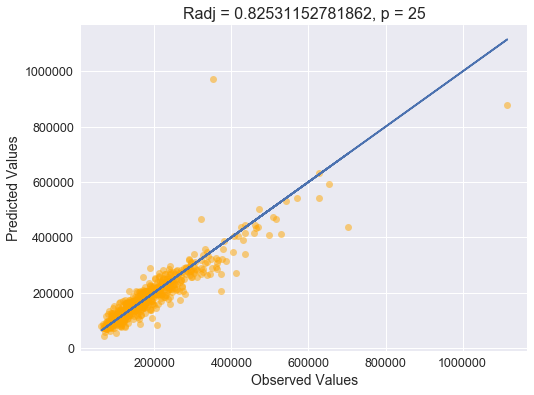

In [118]:
lm = LinearRegression()
lm.fit(train[features], train[output])
radj, mae = mdl_eval(lm, output, features, test, train, 'orange')
mdl_res.append(('OLS', len(features), 'test', radj, mae))

Radj, mae = mdl_eval(lm, output, features, val, train, 'orange', show=False)
mdl_res.append(('OLS', len(features), 'val', Radj, mae))


### ** * b. Random Forest * **

Determine correct parameters to use.

n_estimators          100.000000  
min_samples_leaf        1.000000  
min_samples_split       2.000000  
max_depth                    NaN  
max_leaf_nodes               NaN  
outRadj                 0.985699  
MAE                  3525.916667  

Random Forest Model 

In Sample RSquared:  0.987792709158
Out of sample R-Squared:  0.909075798166
Out of sample Adjusted R-Squared:  0.90556249825
Model Eval (Median Absolute Error):  10615.1991667


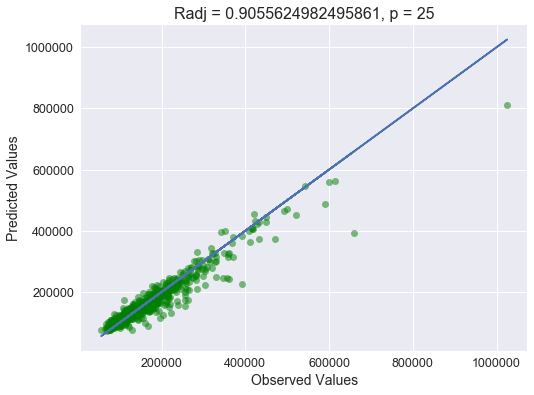

In [119]:
rf = RandomForestRegressor(random_state =42,
                                                n_estimators = 100,
                                                min_samples_leaf = 1,
                                                min_samples_split = 2,
                                                max_depth = None,
                                                max_leaf_nodes = None)
rf.fit(train[features], train[output])
print ('Random Forest Model', '\n')
Radj, mae = mdl_eval(rf, output, features, val, train, 'green')
mdl_res.append(('RF Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(rf, output, features, test, train, 'green', show=False)
mdl_res.append(('RF Regr',len(features), 'test', Radj, mae))

### ** * c. Gradient Boosted Regressor * **

n_estimators          100.000000  
min_samples_leaf        5.000000  
min_samples_split      20.000000  
max_depth                    NaN  
max_leaf_nodes         20.000000  
outRadj                 0.979343  
MAE                  3201.693931  

Gradient Boosting 

In Sample RSquared:  0.91673694524
Out of sample R-Squared:  0.857695960276
Out of sample Adjusted R-Squared:  0.852197349777
Model Eval (Median Absolute Error):  10063.2354932


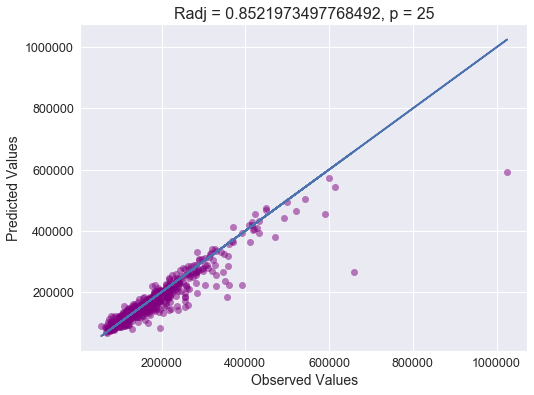

In [120]:
gb = GradientBoostingRegressor(random_state=42,loss='lad', n_estimators=100,
                               min_samples_leaf=5, max_depth=None,
                               min_samples_split=20, max_leaf_nodes=20)
gb.fit(train[features],train[output])
print ('Gradient Boosting', '\n')
Radj, mae = mdl_eval(gb, output, features, val, train, 'purple')
mdl_res.append(('GB Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(gb, output, features, test, train, 'green', show=False)
mdl_res.append(('GB Regr', len(features), 'test', Radj, mae))

### ** * d. elastic net * **

alphas         10.000000  
l1_ratios       1.000000  
OutRAdj         0.989029  
MAE          4259.609621  

Elastic net Model 

In Sample RSquared:  0.886996399598
Out of sample R-Squared:  0.869932471401
Out of sample Adjusted R-Squared:  0.864906678179
Model Eval (Median Absolute Error):  12867.7504339


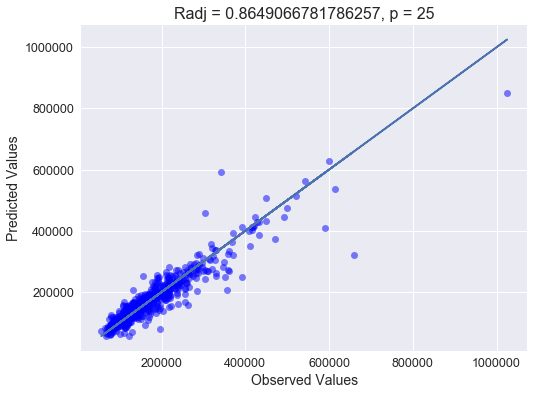

In [121]:
en = ElasticNet(random_state=0,normalize=True,alpha=0.10,l1_ratio=1,max_iter=10000)
en.fit(train[features], train[output])
print ('Elastic net Model', '\n')
Radj, mae = mdl_eval(en, output, features, val, train, 'blue')
mdl_res.append(('EN', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(en, output, features, test, train, 'green', show=False)
mdl_res.append(('EN', len(features), 'test', Radj, mae))

## 7. Comparing Model Performance

In [122]:
res_a10 = pd.DataFrame.from_records(mdl_res, columns=res_labels)
res_a10.drop(0, inplace=True)
res_a10.head(5)

,Model,N_Features,Out_of_sample_data,R_Adj,MAE
1,OLS,25,test,0.825312,14672.185210
2,OLS,25,val,0.864885,12908.639741
3,RF Regr,25,val,0.905562,10615.199167
4,RF Regr,25,test,0.833017,13997.964167
5,GB Regr,25,val,0.852197,10063.235493


## 1. Load dataset - Alpha 85

In [123]:
#set output variable
output = 'ZHVI_AllHomes_next'

In [124]:
path = './data/dataframes/alpha85.csv'
data = pd.read_csv(path)
data['FIPS'] = data.FIPS.apply(str)
data['FIPS'] = data.FIPS.str.zfill(5)
data.drop(['Unnamed: 0'], axis=1, inplace=True)
print('Cols: ', len(data.columns), 'Rows: ', len(data))
drop_columns(data, '_y')
print('Cols, after dropping doubles: ', len(data.columns), 'Rows: ', len(data))
data.head()

Cols:  39 Rows:  10714
Cols, after dropping doubles:  39 Rows:  10714


,Adjusted_gross_income_per_return,County_PriceToRentRatio_AllHomes_current,19300,07100,04800,04470,Property_crimepercent_log,Property_crime_log,02500,Dividends_before_exclusion_per_return,...,10600,Dividends_before_exclusion,59660,00650,Number_of_exemptions_log,Number_of_exemptions_per_return,ZHVI_AllHomes_next,FIPS,STATE,YEAR
0,41.148529,10.108351,7.574493,1.219085,47.703963,22.411182,1.191045,8.586841,12.002002,0.549261,...,9.256089,29414.0,2.233338,4.533934,11.661664,2.166810,104858.333333,10001,0,2000
1,60.782989,10.108351,7.574493,1.219085,47.703963,22.411182,0.095294,8.687569,12.002002,2.170544,...,9.256089,454792.0,2.233338,4.533934,12.984461,2.078910,139341.666667,10003,0,2000
2,43.315463,10.108351,7.574493,1.219085,47.703963,22.411182,0.896158,8.710141,12.002002,1.032915,...,9.256089,85639.0,2.233338,4.533934,11.997596,1.958316,101141.666667,12001,1,2000
3,39.546069,10.108351,7.574493,1.219085,47.703963,22.411182,1.415795,8.849887,12.002002,0.652550,...,9.256089,40631.0,2.233338,4.533934,11.768892,2.074536,113408.333333,12005,1,2000
4,45.895386,10.108351,7.574493,1.219085,47.703963,22.411182,-0.186586,8.414163,12.002002,1.153127,...,9.256089,235389.0,2.233338,4.533934,12.933406,2.027673,97233.333333,12009,1,2000


## 3. Create Training, Validation, and Test Datasets

In [125]:
df = data

### b. Training, Validation, Test data

In [126]:
features = list(set(df.columns) - set([output, 'FIPS', 'YEAR'] ))

In [127]:
train = df[df.YEAR <= 2012]
val = df[df.YEAR == 2013]
test = df[df.YEAR == 2014]

## 6. Modeling

In [128]:
mdl_res = [(0, 0)]
res_labels = ['Model', 'N_Features', 'Out_of_sample_data', 'R_Adj', 'MAE']

### ** * a. OLS * **

In Sample RSquared:  0.607396919845
Out of sample R-Squared:  0.711186335316
Out of sample Adjusted R-Squared:  0.698413249409
Model Eval (Median Absolute Error):  13707.3835248


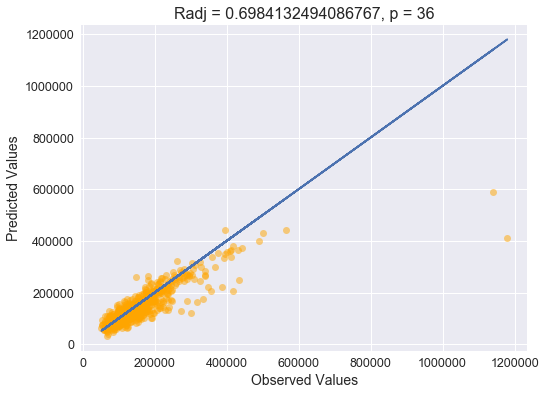

In [129]:
lm = LinearRegression()
lm.fit(train[features], train[output])
radj, mae = mdl_eval(lm, output, features, val, train, 'orange')
mdl_res.append(('OLS', len(features), 'val', radj, mae))

Radj, mae = mdl_eval(lm, output, features, test, train, 'orange', show=False)
mdl_res.append(('OLS', len(features), 'test', Radj, mae))

### ** * b. Random Forest * **

Determine correct parameters to use.

n_estimators           25.000000  
min_samples_leaf        5.000000  
min_samples_split       2.000000  
max_depth                    NaN  
max_leaf_nodes               NaN  
outRadj                 0.967306  
MAE                  3243.994110  

Random Forest Model 

In Sample RSquared:  0.927999343493
Out of sample R-Squared:  0.805888413697
Out of sample Adjusted R-Squared:  0.797303626097
Model Eval (Median Absolute Error):  12907.4131253


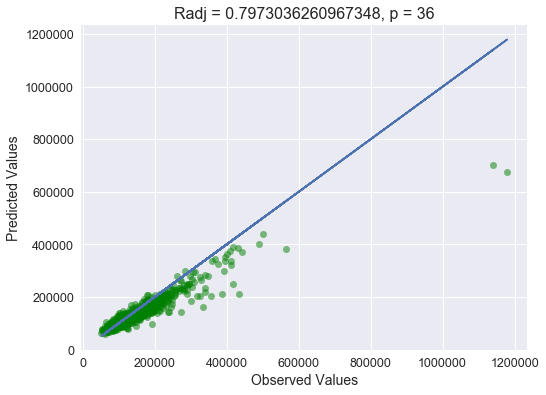

In [130]:
rf = RandomForestRegressor(random_state =42,
                                                n_estimators = 25,
                                                min_samples_leaf = 5,
                                                min_samples_split = 2,
                                                max_depth = None,
                                                max_leaf_nodes = None)
rf.fit(train[features], train[output])
print ('Random Forest Model', '\n')
Radj, mae = mdl_eval(rf, output, features, val, train, 'green')
mdl_res.append(('RF Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(rf, output, features, test, train, 'green', show=False)
mdl_res.append(('RF Regr',len(features), 'test', Radj, mae))


### ** * c. Gradient Boosted Regressor * **

n_estimators          100.00000  
min_samples_leaf       10.00000  
min_samples_split       2.00000  
max_depth               5.00000  
max_leaf_nodes              NaN  
outRadj                 0.95621  
MAE                  3146.98895  

Gradient Boosting 

In Sample RSquared:  0.803484437523
Out of sample R-Squared:  0.689286077147
Out of sample Adjusted R-Squared:  0.675544429453
Model Eval (Median Absolute Error):  13367.7108043


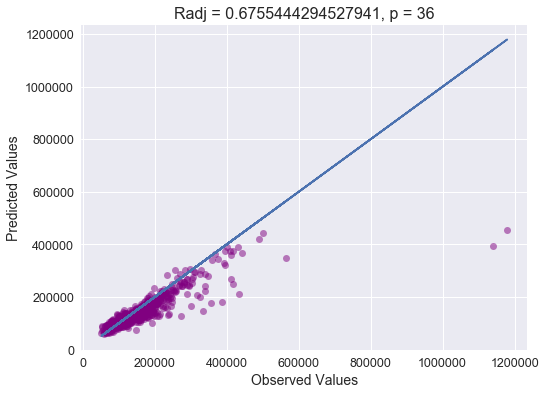

In [131]:
gb = GradientBoostingRegressor(random_state=42,loss='lad', n_estimators=100,
                               min_samples_leaf=10, max_depth=5,
                               min_samples_split=2, max_leaf_nodes=None)
gb.fit(train[features],train[output])
print ('Gradient Boosting', '\n')
Radj, mae = mdl_eval(gb, output, features, val, train, 'purple')
mdl_res.append(('GB Regr', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(gb, output, features, test, train, 'green', show=False)
mdl_res.append(('GB Regr',  len(features), 'test', Radj, mae))

### ** * d. elastic net * **

alphas         10.000000  
l1_ratios       1.000000  
OutRAdj         0.964704  
MAE          3611.973052  

Elastic net Model 

In Sample RSquared:  0.575951545001
Out of sample R-Squared:  0.724844433718
Out of sample Adjusted R-Squared:  0.712675391475
Model Eval (Median Absolute Error):  15156.2169151


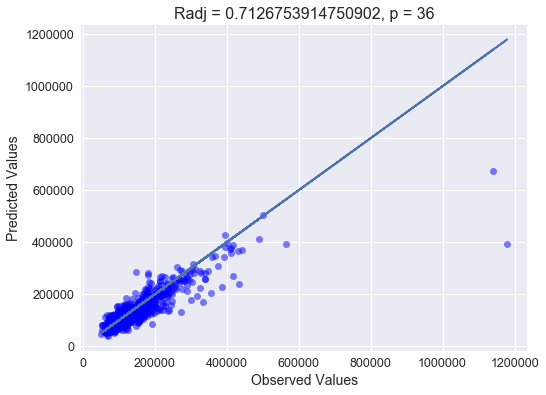

In [132]:
en = ElasticNet(random_state=0,normalize=True,alpha=10,l1_ratio=1,max_iter=10000)
en.fit(train[features], train[output])
print ('Elastic net Model', '\n')
Radj, mae = mdl_eval(en, output, features, val, train, 'blue')
mdl_res.append(('EN', len(features), 'val', Radj, mae))

Radj, mae = mdl_eval(en, output, features, test, train, 'green', show=False)
mdl_res.append(('EN', len(features), 'test', Radj, mae))

## 7. Comparing Model Performance

In [133]:
res_a85 = pd.DataFrame.from_records(mdl_res, columns=res_labels)
res_a85.drop(0, inplace=True)
res_a85

,Model,N_Features,Out_of_sample_data,R_Adj,MAE
1,OLS,36,val,0.698413,13707.383525
2,OLS,36,test,0.694855,13931.908449
3,RF Regr,36,val,0.797304,12907.413125
4,RF Regr,36,test,0.723129,14753.970607
5,GB Regr,36,val,0.675544,13367.710804
6,GB Regr,36,test,0.622654,14378.622882
7,EN,36,val,0.712675,15156.216915
8,EN,36,test,0.693079,16056.241978


In [134]:
res_c10['data'] = 'covar, 2010-2016'
res_c85['data'] = 'covar, 1985-2015'
res_a10['data'] = 'alpha, 2010-2016'
res_a85['data'] = 'alpha, 1985-2015'

In [135]:
res = pd.concat([res_a10, res_a85, res_c10, res_c85])

In [138]:
res = res[res.Out_of_sample_data == 'test' ]

In [166]:
res[res.MAE == res.MAE.min()]

,Model,N_Features,Out_of_sample_data,R_Adj,MAE,data
6,GB Regr,42,test,0.779405,8644.569775,"covar, 1985-2015"


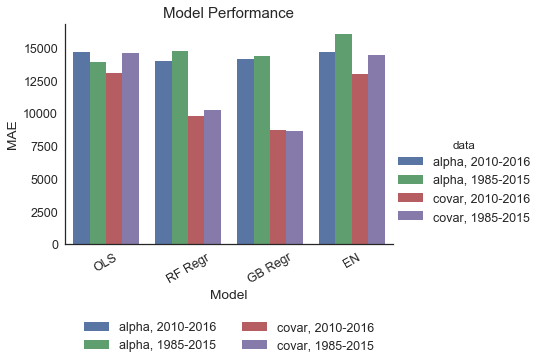

In [164]:
sns.set(font_scale=1.25)
with sns.axes_style("white"):
    b = sns.factorplot('Model', 'MAE', data=res, hue='data',kind='bar', aspect=1.5)
b.set_xticklabels(rotation=30)
pl.title('Model Performance')
pl.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, -.3))

In [61]:
map_df = data[['FIPS']+[output]+features]

In [62]:
map_df['FIPS'] = map_df['FIPS'].apply(int)

/Users/baileygriswold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
map_df['predicted'] = gb.predict(map_df[features])

In [64]:
map_df['% error'] = ((map_df[output] - map_df['predicted'])/ map_df[output]) * 100

In [65]:
map_df = map_df[map_df['% error'] != map_df['% error'].max()]

In [66]:
map_df = map_df[map_df['% error'] != map_df['% error'].min()]

In [67]:
from bqplot import pyplot as plt
from bqplot import *

map_fig = plt.figure(title='Prediction Error by Model (% of Actual Value)', min_width=1300, min_height=1000)
map_tt = Tooltip(fields=['name', 'color'], labels=['COUNTY'])
map_res = plt.geo(map_data=topo_load('map_data/USCountiesMap.json'), stroke_color='black',
                 colors={'default_color': 'Gray'},
                  scales={'projection': AlbersUSA(),
                         'color': ColorScale(scheme='RdYlBu')},
                  color=dict(zip(map_df['FIPS'], map_df['% error'])), tooltip=map_tt)
map_fig

A Jupyter Widget

In [68]:
NYC = ['62005', '62047', '62061', '62081', '62085']

In [69]:
map_df[map_df['FIPS'].isin(NYC)]
#map_df['FIPS'] == NYC

,FIPS,ZHVI_AllHomes_next,Adjusted_gross_income_per_return,Wages_and_salaries,04470,02650,59720_log,Property_crime_log,04800,STATE,...,County_PriceToRentRatio_AllHomes_current,rent_price_persqft_AllHomes_current,Wages_and_salaries_per_return,County_PctOfHomesDecreasingInValues_AllHomes_current,00200,Dividends_before_exclusion_per_return,00650,01400,predicted,% error
